<h1>Importowanie wymaganych bibliotek</h1>

In [1]:
import pandas as pd
import spotler.api.model_data.model_data_lib as modlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import top_k_accuracy_score,make_scorer, balanced_accuracy_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours
import matplotlib.ticker as plticker
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


In [2]:
# %load_ext pycodestyle_magic

In [3]:
%pycodestyle_off

UsageError: Line magic function `%pycodestyle_off` not found.


<h1>Wczytanie danych</h1>

<h3>Ustawienie ścieżek do plików z danymi i query do wygenerowania pliku CSV na podstawie danych w bazie danych</h3>

In [4]:
track_genres_query = modlib.TRACK_GENRE_SQL_QUERY
track_simple_genres_query = modlib.TRACK_SIMPLE_GENRE_SQL_QUERY

db_path = "spotler/db.sqlite3"
csv_name = "track_genres.csv"
csv_simple_genre_name = "track_simple_genres.csv"

<h3>Tworzenie CSV na podstawie kwerendy</h3>

In [5]:
modlib.create_csv_from_query(db_path, csv_name, track_genres_query, "\t")

['track_id', 'name', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'loudness', 'liveness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'genre_name']


['track_id',
 'name',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'key',
 'loudness',
 'liveness',
 'mode',
 'speechiness',
 'tempo',
 'time_signature',
 'valence',
 'genre_name']

<h3> Wczytanie pliku csv</h3>

In [6]:
df = pd.read_csv(csv_name, sep="[\t]")

/tmp/ipykernel_4943/1184186776.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(csv_name, sep="[\t]")


<h3>Przykładowe dane w pliku</h3>

In [7]:
df.head()

,track_id,name,acousticness,danceability,energy,instrumentalness,key,loudness,liveness,mode,speechiness,tempo,time_signature,valence,genre_name
0,1Qrg8KqiBpW07V7PNxwwwL,Kill Bill,0.0521,0.644,0.735,0.144,8,-5.747,0.161,1,0.0391,88.980,4,0.418,pop
1,1Qrg8KqiBpW07V7PNxwwwL,Kill Bill,0.0521,0.644,0.735,0.144,8,-5.747,0.161,1,0.0391,88.980,4,0.418,r&b
2,1Qrg8KqiBpW07V7PNxwwwL,Kill Bill,0.0521,0.644,0.735,0.144,8,-5.747,0.161,1,0.0391,88.980,4,0.418,rap
3,7ro0hRteUMfnOioTFI5TG1,WHERE SHE GOES,0.1430,0.652,0.800,0.629,9,-4.019,0.112,0,0.0614,143.978,4,0.234,reggaeton
4,7ro0hRteUMfnOioTFI5TG1,WHERE SHE GOES,0.1430,0.652,0.800,0.629,9,-4.019,0.112,0,0.0614,143.978,4,0.234,trap latino


<h3>Analiza kompletności rekordów pliku</h3>

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148506 entries, 0 to 148505
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          148506 non-null  object 
 1   name              148506 non-null  object 
 2   acousticness      148506 non-null  float64
 3   danceability      148506 non-null  float64
 4   energy            148506 non-null  float64
 5   instrumentalness  148506 non-null  float64
 6   key               148506 non-null  int64  
 7   loudness          148506 non-null  float64
 8   liveness          148506 non-null  float64
 9   mode              148506 non-null  int64  
 10  speechiness       148506 non-null  float64
 11  tempo             148506 non-null  float64
 12  time_signature    148506 non-null  int64  
 13  valence           148506 non-null  float64
 14  genre_name        148506 non-null  object 
dtypes: float64(9), int64(3), object(3)
memory usage: 17.0+ MB


<h1>Wstępna analiza danych</h1>

<h3>Badanie częstotliwości wszystkich gatunków</h3>

<h5>Sprawdzamy jak bardzo scentralizowane (lub nie) są gatunki utworów na spotify. W praktyce to oznacza, że sprawdzamy czy są jakieś gatunki, które są uniwersalne i pojawiają się regularnie, czy też są jakieś gatunki, które pojawiają się np. tylko raz (co w przypadku analizy jest bardzo nieporządane)

In [9]:
genres_freq = df["genre_name"].value_counts()
genres_freq = pd.DataFrame({"genres_number": genres_freq.index, "genres_appear": genres_freq.values})[
    "genres_appear"].value_counts()

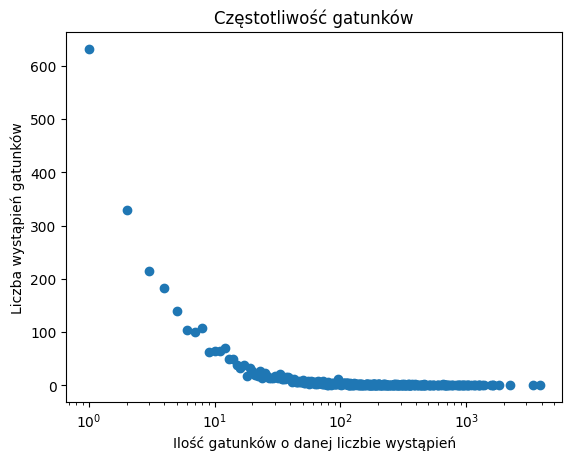

In [10]:
fig, ax = plt.subplots()
ax.scatter(genres_freq.index, genres_freq.values)
plt.xlabel("Ilość gatunków o danej liczbie wystąpień")
plt.ylabel("Liczba wystąpień gatunków")
plt.xscale("log")
plt.title("Częstotliwość gatunków")

plt.show()

<h3>Ograniczenie gatunków na podstawie ich popularności i analizy leksykalnej</h3>

<h5>Wykorzystujemy inne query SQL aby wydobyć uproszczone gatunki utworów. Te gatunki które nie pasowały do żadnego z uproszczonych gatunków naturalnie ignorujemy</h5>

In [11]:
all_columns =modlib.create_csv_from_query(
    db_path, csv_simple_genre_name, track_simple_genres_query, "\t")

# column_names = [
#     'acousticness', 'danceability', 'energy',
#     'instrumentalness', 'key', 'loudness',
#     'liveness', 'mode', 'speechiness',
#     'tempo', 'time_signature', 'valence'
# ]
column_names = all_columns[2:-1]

['track_id', 'name', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'loudness', 'liveness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'simplyfied_name']


<h3>Wczytanie nowego pliku csv z ograniczoną liczbą garunków do których może być sklasyfikowany utwór</h3>

In [12]:
df = pd.read_csv(csv_simple_genre_name, sep="[\t]")

/tmp/ipykernel_4943/2989146857.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(csv_simple_genre_name, sep="[\t]")


<h3>Liczba utworów o danym gatunku</h3>

<h5>Sprawdzamy jak wygląda rozkład gatunków wśród utworów aby sprawdzić czy mamy do czynienia z setem niezbalansowanym</h5>

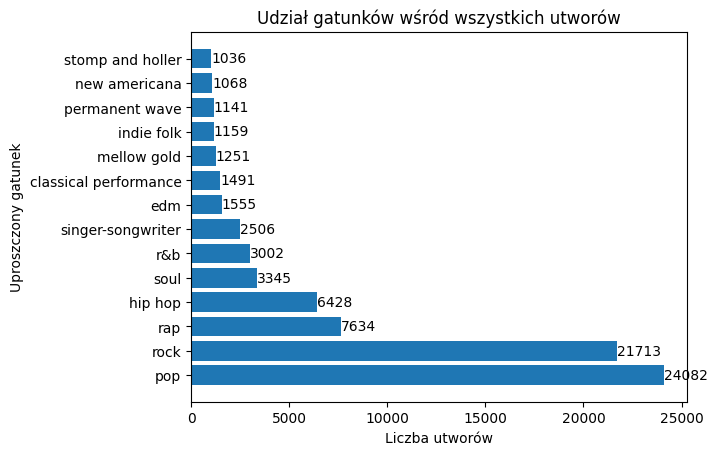

<Figure size 40000x10000 with 0 Axes>

In [37]:
def draw_chart_of_genre_count(df,title):
    simplified_genre_count = (df["simplyfied_name"].value_counts())
    fig, ax = plt.subplots()

    bars = ax.barh(simplified_genre_count.index, simplified_genre_count.values)
    ax.bar_label(bars)
    ax.set_xlabel("Liczba utworów")
    ax.set_ylabel("Uproszczony gatunek")
    ax.set_title(title)
    plt.figure(figsize=(400,100))

    plt.tight_layout()
    plt.show()
draw_chart_of_genre_count(df, "Udział gatunków wśród wszystkich utworów")

<h3>Badanie procentowego udziału gatunków</h3>

<h5>Aby upewnić się, że mamy do czynienia z setem niezbalansowanym sprawdzamy procentowy udział gatunków</h5>

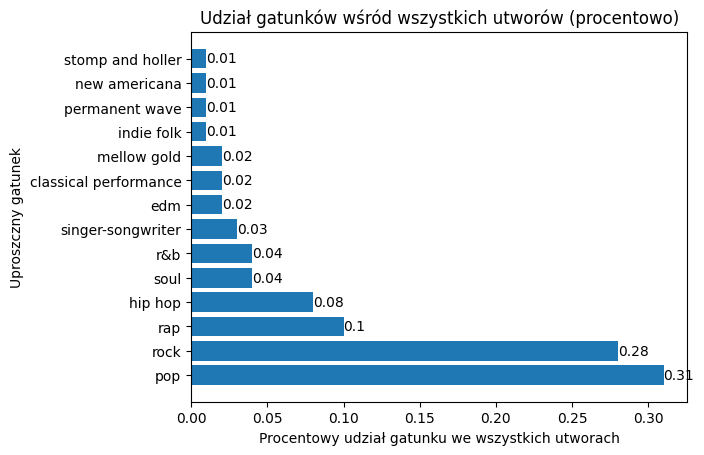

In [14]:
simplified_genre_count = (df["simplyfied_name"].value_counts())
sum = simplified_genre_count.values.sum()
fig, ax = plt.subplots()

bars = ax.barh(
    simplified_genre_count.index,
    [round(amount/sum, 2) for amount in simplified_genre_count.values])

ax.bar_label(bars)
ax.set_xlabel("Procentowy udział gatunku we wszystkich utworach")
ax.set_ylabel("Uproszczny gatunek")
ax.set_title("Udział gatunków wśród wszystkich utworów (procentowo)")

plt.show()

<h5>Widzimy, że w związku z tym, że wiele gatunków stanowi ~1% zbioru, to mamy do czynienia ze skarajnie niezbalansowanym zbiorem danych. W związku z tym jesteśmy zmuszeni podjąć dodatkowe kroki poczas analizy, i odpowiednio interpretować ich wyniki.</h5>

<h1>Resamplowanie setu</h1>

<h5>W celu odpowiedniego rozpozaniania własności wszystkich klas zalecane jest aby przykładowo reamplować zbiór danych w celu wyrównania równowagi między klasami, lub żeby wyróżnić czynniki które stanowią, że obiekt należy do danej klasy.</h5>

In [15]:
def get_resampled_set(original_set:pd.DataFrame, resampling_strategy):
    """
    Retrieve resampled set of tracks, based original set and resapling strategy\n
    original_set: DataFrame with track names, id and all qualities that predicts and a genre itself\n
    resampling_strategy: strategy of resampling from imbalanced-learn library
    """
    X = original_set.iloc[:, 2:14].values
    Y = original_set.iloc[:, 14].values
    X_rus, y_rus = resampling_strategy.fit_resample(X, Y)
    new_df_list = [np.concatenate([row_data, [row_class]]) for row_data,row_class in zip(X_rus,y_rus)]
    resampled_set = pd.DataFrame( new_df_list,
               columns=all_columns[2:])
    return resampled_set


<h5>Oversampling to metoda balansowania setu polegająca na zwiększeniu liczby obiektów z mniej popularnymi klasami do rozmiaru klasy najbardziej powszechnej</h5>

In [16]:
oversampled_df = get_resampled_set(df, RandomOverSampler())

<h5>Undersampling to metoda balansowania setu polegająca na zmniejszeniu liczby obiektów z najpopularniejszymi do rozmiaru klasy najmniejsz powszechnej</h5>

In [17]:
undersampled_df = get_resampled_set(df, RandomUnderSampler())

<h5>Nearest Neighbour to undersamplingowa metoda balansowania setu polegająca na usuwaniu obiektów, które mogą być na granicy klasyfikacji do różnych klas</h5>

In [18]:
nearest_neighbours_df = get_resampled_set(df, EditedNearestNeighbours())
nearest_neighbours_df.head()

,acousticness,danceability,energy,instrumentalness,key,loudness,liveness,mode,speechiness,tempo,time_signature,valence,simplyfied_name
0,0.95,0.272,0.153,0.892,10.0,-20.058,0.312,1.0,0.0364,101.712,4.0,0.471,classical performance
1,0.95,0.272,0.153,0.892,10.0,-20.058,0.312,1.0,0.0364,101.712,4.0,0.471,classical performance
2,0.905,0.117,0.0539,0.849,11.0,-20.521,0.102,0.0,0.04,79.136,4.0,0.035,classical performance
3,0.964,0.119,0.031,0.165,2.0,-31.179,0.111,1.0,0.0483,88.858,4.0,0.0388,classical performance
4,0.964,0.119,0.031,0.165,2.0,-31.179,0.111,1.0,0.0483,88.858,4.0,0.0388,classical performance


In [19]:
nearest_neighbours_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18373 entries, 0 to 18372
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   acousticness      18373 non-null  object
 1   danceability      18373 non-null  object
 2   energy            18373 non-null  object
 3   instrumentalness  18373 non-null  object
 4   key               18373 non-null  object
 5   loudness          18373 non-null  object
 6   liveness          18373 non-null  object
 7   mode              18373 non-null  object
 8   speechiness       18373 non-null  object
 9   tempo             18373 non-null  object
 10  time_signature    18373 non-null  object
 11  valence           18373 non-null  object
 12  simplyfied_name   18373 non-null  object
dtypes: object(13)
memory usage: 1.8+ MB


<h5>Analiza wyników resamplingu na podstawie oceny średniej dokładności modelu w ramach cross-validacji</h5>

In [20]:
def cross_validate_set_and_model(model, set_df, scorer):
    """
    Return a mean of accuracy scores from cross validating the model with given set\n
    model - scikit-learn model that is evaluated\n
    set_df - tracks dataset in the form of pandas DataFrame 
    """
    return cross_val_score(model,
                            set_df[column_names].values,
                            set_df["simplyfied_name"].values,
                            cv=3,
                            scoring=make_scorer(scorer)
                            ).mean()



original_lda_cross_score = cross_validate_set_and_model(LinearDiscriminantAnalysis(), df, accuracy_score)
undersampled_lda_cross_score = cross_validate_set_and_model(LinearDiscriminantAnalysis(), undersampled_df, accuracy_score)
oversampled_lda_cross_score = cross_validate_set_and_model(LinearDiscriminantAnalysis(),oversampled_df, accuracy_score)
nearest__neighbours_lda_cross_score = cross_validate_set_and_model(LinearDiscriminantAnalysis(), nearest_neighbours_df, accuracy_score)

original_lda_cross_balanced_score = cross_validate_set_and_model(LinearDiscriminantAnalysis(), df, balanced_accuracy_score)
undersampled_lda_cross_balanced_score = cross_validate_set_and_model(LinearDiscriminantAnalysis(), undersampled_df,balanced_accuracy_score)
oversampled_lda_cross_balanced_score = cross_validate_set_and_model(LinearDiscriminantAnalysis(),oversampled_df, balanced_accuracy_score)
nearest__neighbours_lda_cross_balanced_score = cross_validate_set_and_model(LinearDiscriminantAnalysis(), nearest_neighbours_df, balanced_accuracy_score)

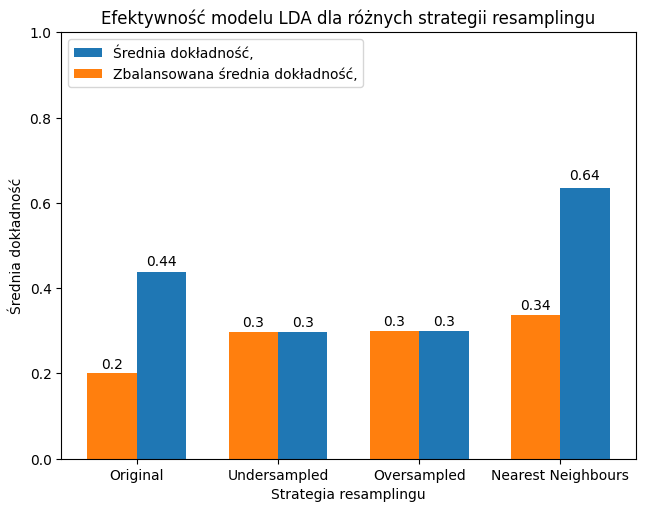

In [27]:
def put_label_on_a_bar(bars):
    """
    Put labels on provided bars with its height
    """
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2,
                1.02*height,round(height,2),
                ha='center', va='bottom')

_,ax = plt.subplots()
bar_width = -0.35
labels_for_standard_score = ax.bar(["Original","Undersampled", "Oversampled", "Nearest Neighbours"],
                [original_lda_cross_score,
                 undersampled_lda_cross_score,
                 oversampled_lda_cross_score,
                 nearest__neighbours_lda_cross_score
                 ],
                 width=-bar_width,
                 label="Średnia dokładność,",
                 align="edge")

labels_for_balanced_score = ax.bar(["Original","Undersampled", "Oversampled", "Nearest Neighbours"],
                [original_lda_cross_balanced_score,
                 undersampled_lda_cross_balanced_score,
                 oversampled_lda_cross_balanced_score,
                 nearest__neighbours_lda_cross_balanced_score
                 ],
                 width=bar_width,
                 label="Zbalansowana średnia dokładność,",
                 align="edge")
plt.tight_layout()
ax.set_title("Efektywność modelu LDA dla różnych strategii resamplingu")
ax.set_xlabel("Strategia resamplingu")
ax.set_ylabel("Średnia dokładność")
ax.legend(loc="upper left")
put_label_on_a_bar(labels_for_standard_score)
put_label_on_a_bar(labels_for_balanced_score)
ax.set_ylim(0,1)
plt.show()
#df=undersampled_df

<h5>Na podstawie powyższych wyników widzimy, że zarówno Oversampling i Undersampling w przypadku naszego zbioru danych pogarszają wyniki klasyfikacji</h5>
<h5>Metoda Nearest Neigbours okazała się drastycznie poprawić wyniki klasyfikacji (~20 p.p). W związku z tym następne kroki podczas analizy będziemy wykonywac dla zbioru oryginalnego oraz tego zresamplowanego przez Nearest Neighbours</h5>

<h3>Badanie liczności gatunków z resamplowanego setu</h3>

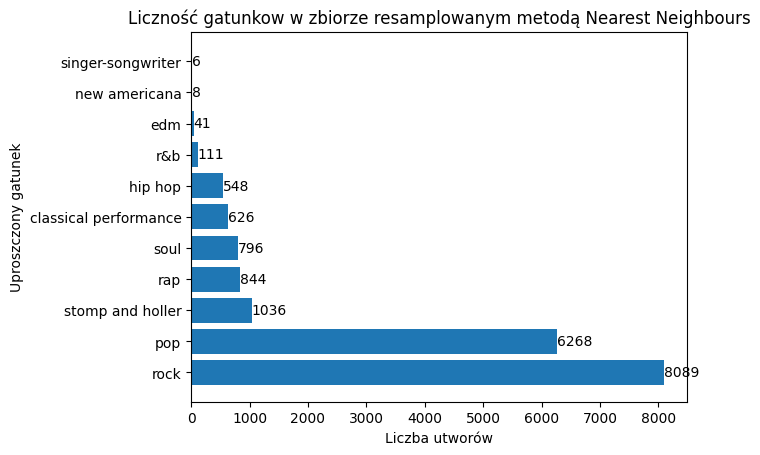

<Figure size 40000x10000 with 0 Axes>

In [38]:
draw_chart_of_genre_count(nearest_neighbours_df,"Liczność gatunkow w zbiorze resamplowanym metodą Nearest Neighbours" )

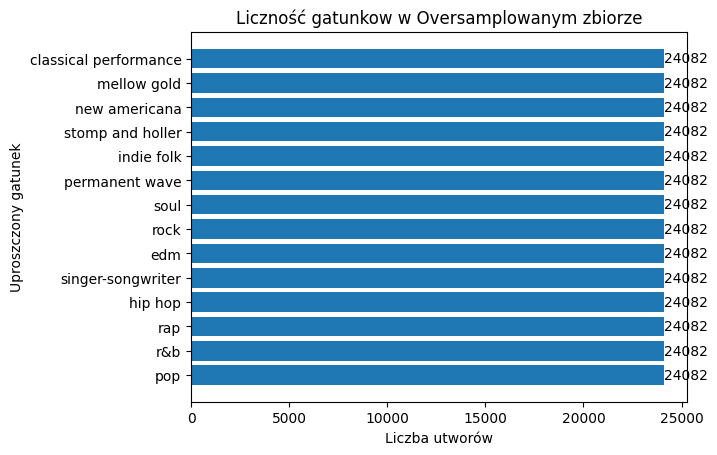

<Figure size 40000x10000 with 0 Axes>

In [41]:
draw_chart_of_genre_count(oversampled_df,"Liczność gatunkow w Oversamplowanym zbiorze" )

<h5>Okazuje się, że Nearest Neigbour nie pomogło nam zbalansować setu (tak jak undersamping i oversampling by zrobiły)</h5>
<h5>Mimo to, warto rozważyć analizę tego setu ze względu na możliwość analizy efektywności modeli klasyfikujących z wykorzystaniem testów, które biorą pod uwagę wyłącznie najbardziej prawdopodobny gatunek (co w przypadku charakterystyki naszego zbioru nie zawsze jest proste do stwierdzenia)</h5>

<h1>Badanie rozkładu cech ilościowych</h1>


<h5>Sprawdzamy podstawowe rozkłady cech ilościowych utworu służących do predykcji gatunku w celu znalezienia jakichś zależności lub anomalii</h5>

In [194]:
def chart_value_count(dataframe, index):
    """
    Evaluate the frequency of each value from dataframe and return index and count of value from this index in tuple\n
    dataframe: Pandas DataFrame, as the source of data\n
    index: dataframe column name used to identify data that we want to count\n
    
    """
    if index in dataframe:
        counts = dataframe[index].value_counts()
        return counts.index, counts.values


def create_multiple_frequency_charts(
    df,
    index_keys,
    axis,
    number_of_columns
):
    """
    Create charts of frequency of values for multiple columns of the same DataFrame\n
    df: Pandas DataFrame - source of data\n
    index_keys: DataFrame column names used to specify the qualities that we want to get count of\n
    axis: matplotlib axis object, used to draw charts on\n
    number_of_columns: number of columns with regard to number of charts in each row\n


    """

    for index, index_key in enumerate(index_keys):
        row_number = int(index/number_of_columns)
        data_count = chart_value_count(df, index_key)

        current_axis = axis[
            row_number,
            index-row_number*number_of_columns
        ]

        current_axis.scatter(data_count[0], data_count[1], s=0.5)
        current_axis.set_title(index_key)
        current_axis.set_xlabel("value")
        current_axis.set_ylabel("count")

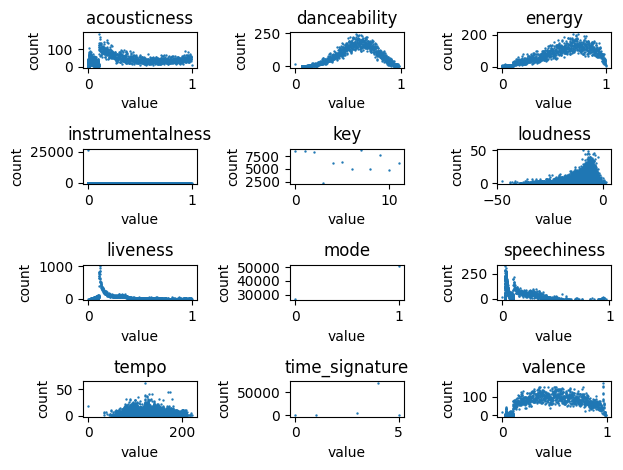

In [195]:
figure, axis = plt.subplots(4, 3)


create_multiple_frequency_charts(df, column_names, axis, 3)

plt.tight_layout()
plt.show()

<h3>Badanie liczby gatunków utworu</h3>

<h5>Sprawdzamy jak powszechne jest, że utwór ma więcej niż jeden gatunek - z natury źródła danych wiemy, że gatunek utworu jest dedukowany na podstawie gatunku artysty. W związku z tym sprawdzamy jak wiele artystów tworzy w wielu gatunkach.</h5>

In [196]:
genres_per_track = nearest_neighbours_df.groupby(column_names).value_counts()
genres_per_track = pd.DataFrame({"genres_of_track": genres_per_track.values})["genres_of_track"].value_counts()

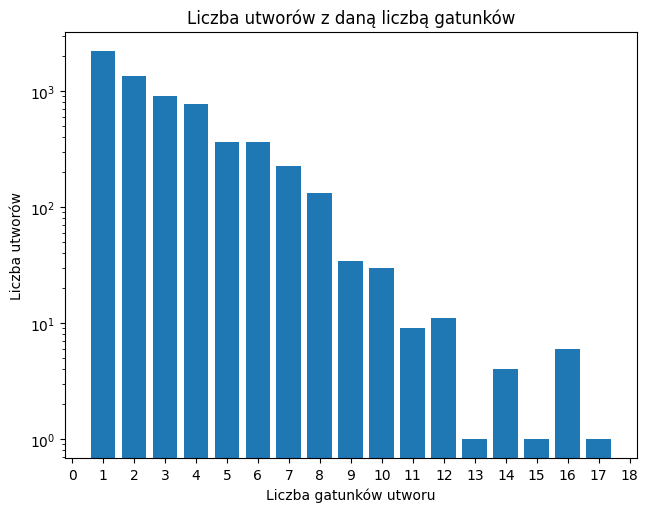

In [197]:
fig, ax = plt.subplots()
ax.bar(x=genres_per_track.index, height=genres_per_track.values)
loc = plticker.MultipleLocator(base=1.0)
ax.xaxis.set_major_locator(loc) 
ax.set_yscale("log")
plt.tight_layout()
ax.set_xlabel("Liczba gatunków utworu")
ax.set_ylabel("Liczba utworów")
plt.title("Liczba utworów z daną liczbą gatunków")
plt.show()


<h5>Na podstawie powyższego wykresu widzimy, że jest bardzo dużo utworów z więcej niż jednym gatunkiem. Jest to bardzo ważne, ponieważ na podstawie tej cechy trzeba odpowiednio wybrać metryki oceniające modele klasyfikujące tak aby uwzględniały wiele poprawnych klas obiektu</h5>

<h1>Macierz korelacji</h1>

<h5>Tworzymy prostą macierz korelacji aby sprawdzić korelacje liniowe pomiędzy cechami predykującymi</h5>

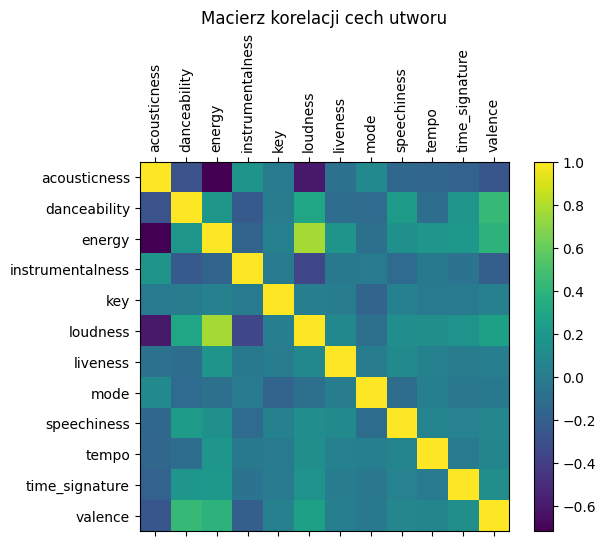

In [36]:


corr = df[column_names].corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr)
plt.title("Macierz korelacji cech utworu")
fig.colorbar(cax)
ax.set_xticks(range(len(corr.columns)), corr.columns)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
#plt.xticks(range(len(corr.columns)), range(len(corr.columns)))
plt.yticks()
plt.show()


<h5>Na tym etapie od razu widzimy stosunkowo dużą korelacje między głośnością oraz energią</h5>

<h1>Korelacje wszystkich cech ilościowych</h1>

<h5>Macierz korelacji jest uproszczeniem pod tym względem, że uwzględnia ona tylko korelacje liniowe, jeżeli cechy są w skorelowane w inny sposób to możemy tego nie zauważyć. W związku z tym należy wyznaczyć wykresy zależności wartości każdej cechy do każdej innej cechy</h5>

In [199]:
def create_all_correlation_charts_for_attribute(attribute_to_compare, all_atributes, datasource):
    """
    Plot and show charts of correlation for attribute_to_compare against all_other atributes.\n
    attribute_to_compare: attribute that is to be compared with each atribute of all_atributes\n
    all_atributes: all atributes that attribute_to_compare is compared against\n
    datasource: Pandas DataFrame that is used as a source of data
    
    """
    number_of_columns = 3
    _, ax = plt.subplots(4, number_of_columns)
    for index, attribute in enumerate(all_atributes):
        row_number = int(index/number_of_columns)
        current_axis = ax[
            row_number,
            index-row_number*number_of_columns
        ]

        current_axis.scatter(df[attribute_to_compare], datasource[attribute], s=0.0001)
        current_axis.set_xlabel(attribute_to_compare)
        current_axis.set_ylabel(attribute)
    plt.tight_layout()
    plt.show()

<h3>Badanie korelacji akustyczności</h3>

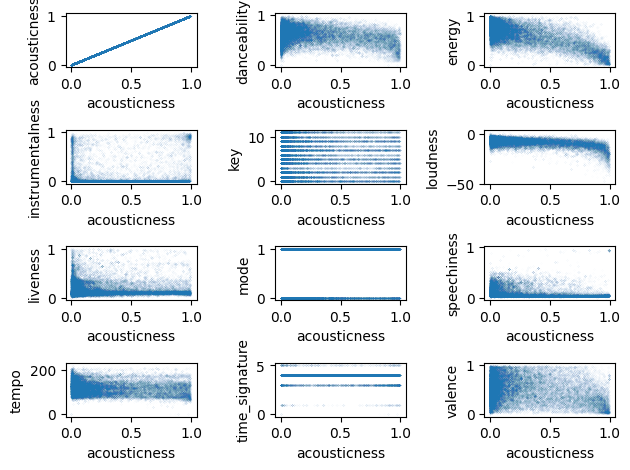

In [ ]:
create_all_correlation_charts_for_attribute("acousticness", column_names, df)

<h3>Badanie korelacji energi</h3>

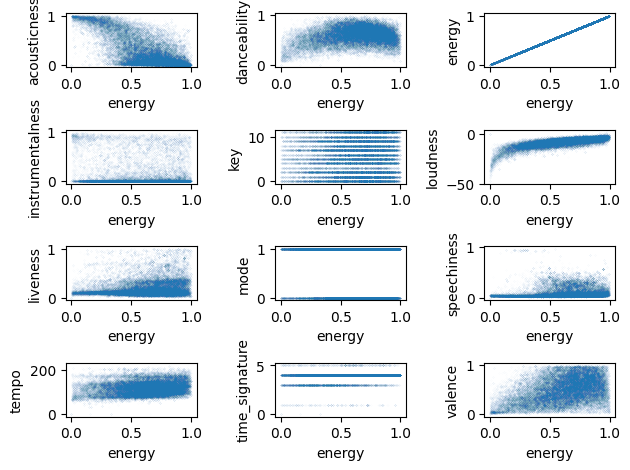

In [ ]:
create_all_correlation_charts_for_attribute("energy", column_names, df)

<h3>Badanie korelacji instrumentalności</h3>

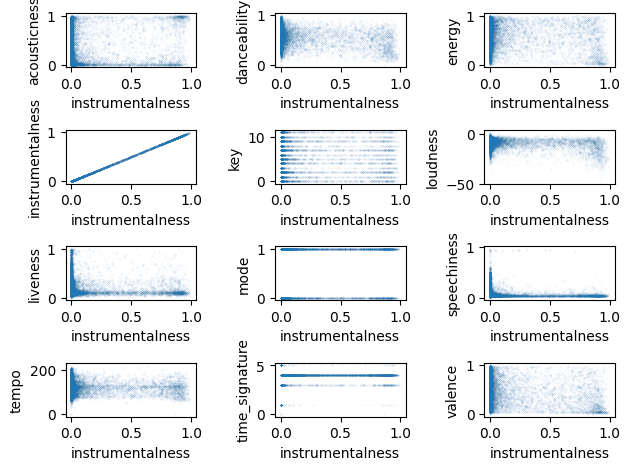

In [ ]:
create_all_correlation_charts_for_attribute("instrumentalness", column_names, df)

<h3>Badanie korelacji klucza</h3>

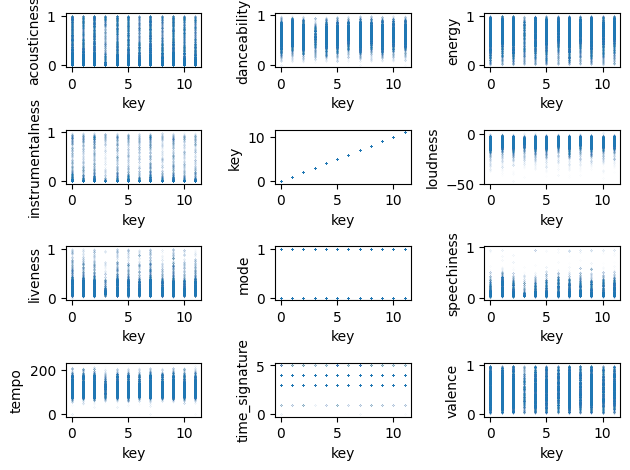

In [ ]:
create_all_correlation_charts_for_attribute("key", column_names, df)

<h3>Badanie korelacji głośności</h3>

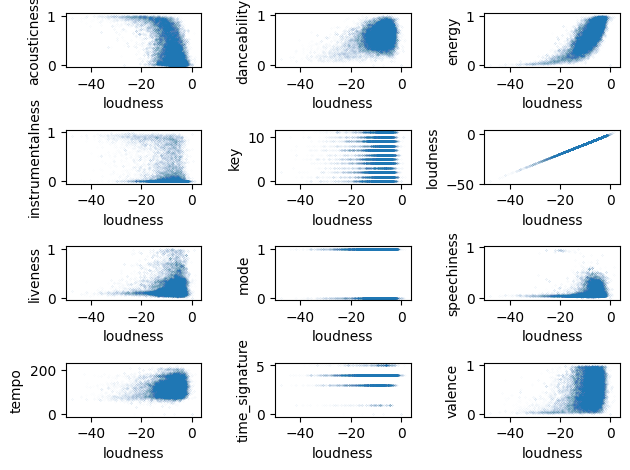

In [ ]:
create_all_correlation_charts_for_attribute("loudness", column_names, df)

<h3>Badanie korelacji żywotności</h3>

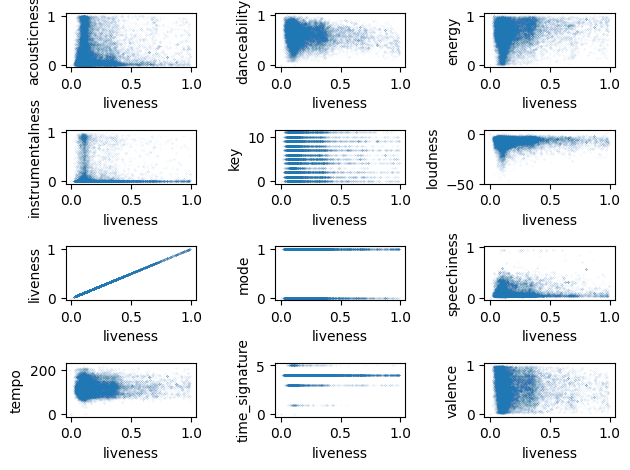

In [ ]:
create_all_correlation_charts_for_attribute("liveness", column_names, df)

<h3>Badanie korelacji modalności</h3>

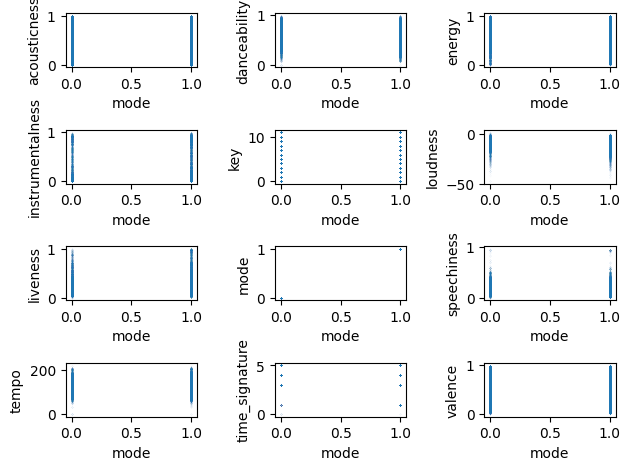

In [ ]:
create_all_correlation_charts_for_attribute("mode", column_names, df)

<h3>Badanie korelacji współczynnika obecności słów</h3>

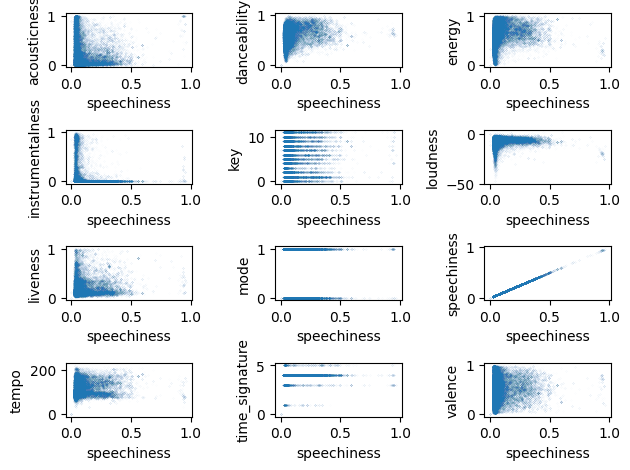

In [ ]:
create_all_correlation_charts_for_attribute("speechiness", column_names, df)

<h3>Badanie korelacji tempa</h3>

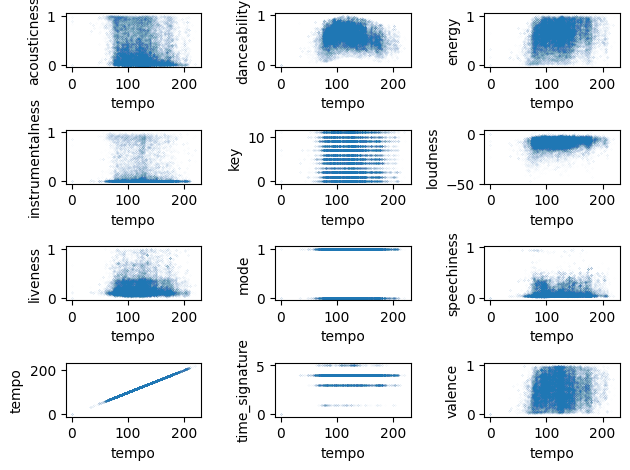

In [ ]:
create_all_correlation_charts_for_attribute("tempo", column_names, df)

<h3>Badanie korelacji sygnatury czasowej</h3>

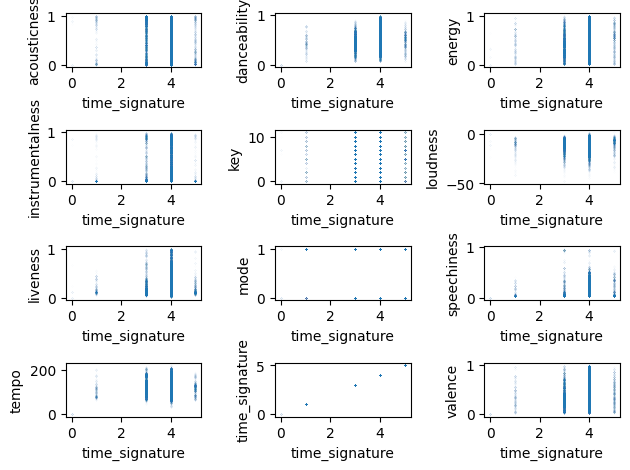

In [ ]:
create_all_correlation_charts_for_attribute("time_signature", column_names, df)

<h3>Badanie korelacji pozytywności</h3>

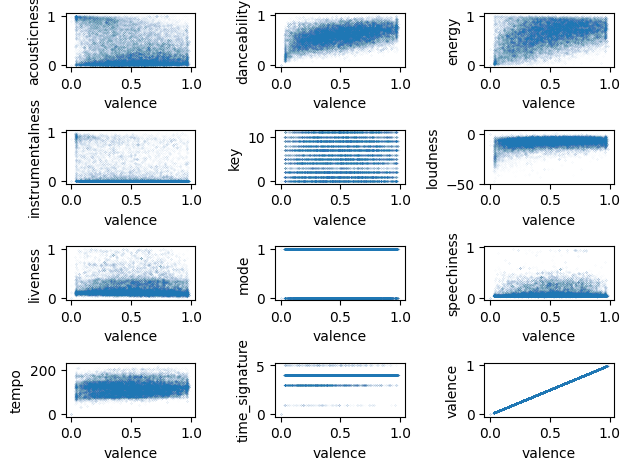

In [ ]:
create_all_correlation_charts_for_attribute("valence", column_names, df)

<h5>Na podstawie powyższej analizy zależność cech predykujących dowiedzieliśmy się, że faktycznie istnieje silna korelacja energi i głośności, ale oprócz tego większąść cech jest mocno związana z niskim poziomem instrumentalności, co może sugerować, że jeżeli znajdziemy gatunek, który ma wysoki poziom instrumentalności, to powinien on być dobrze predykowany</h5>

<h1>Dzielenie zbioru danych na set uczący i testujący<h1>
<h5>W tym kroku dzielimy zbiór danych na dwa rozłączne podzbiory służące do nauki i testowania modelu.</h5>

In [ ]:
X_train, X_test,  Y_train, Y_test = train_test_split(df[column_names].values,
                                                     df["simplyfied_name"].values,
                                                     test_size=0.2,
                                                     random_state=42,
                                                     stratify=df["simplyfied_name"].values)

<h5>Analogiczną procedure wykonujemy dla zbioru który został poddany ponownemu próbkowaniu</h5>

In [ ]:
X_resampled_train, X_resampled_test,  Y_resampled_train, Y_resampled_test = train_test_split(
                                                     nearest_neighbours_df[column_names].values,
                                                     nearest_neighbours_df["simplyfied_name"].values,
                                                     test_size=0.2,
                                                     random_state=42,
                                                     stratify=nearest_neighbours_df["simplyfied_name"].values)

<h1>Trenowanie modeli i badanie ich efektywności</h1>

In [ ]:
def run_top_k_accuracy_score_of_model(model, X_test, Y_test, k):
    """
    Return model scores of top_k_accuracy_metric with specified nuber of accepted classes - k
    """
    Y_score = [model.predict_proba([[float(xx) for xx in x]])[0] for x in X_test]
    return top_k_accuracy_score(Y_test, Y_score, k=k)


def draw_chart_of_k_accuracy_score_of_model(model, X_test, Y_test):
    """
    Plot a chart of models scores of top_k_accuracy for each k
    """
    _, ax = plt.subplots()
    class_range = range(1, len(model.classes_))
    ax.scatter(class_range, [run_top_k_accuracy_score_of_model(
        model, X_test, Y_test, k=k) for k in class_range])
    ax.set_xticks(class_range)
    ax.set_xlabel("Liczba akceptowanych klasyfikatorów")
    ax.set_ylabel("Jakość modelu")

    plt.show()

In [ ]:
def get_top_k_accuracy_of_model(model, X_test, Y_test):
    """
    Get models scores for top_k_accuracy for each k
    """
    class_range = range(1, len(model.classes_))
    return [run_top_k_accuracy_score_of_model(
        model, X_test, Y_test, k=int(k)) for k in class_range]

def draw_chart_of_k_accuracy_score_of_models(models, X_test_sets, Y_test_sets, model_labels):
    """
    Plot chart that compares top_k_accuracy scores of provided models for each k.
    Returns dictionary with accuracy of the models marked accordingly to model_labels 
    """
    _,ax = plt.subplots()
    models_accuracy = {}
    models_accuracy["Akceptowane klasy"]=[]
    
    for model, X_test, Y_test, label in zip(models,X_test_sets,Y_test_sets, model_labels):
        model_scores = get_top_k_accuracy_of_model(model, X_test, Y_test)
        model_class_range = range(1, len(model.classes_))
        models_accuracy[label+" score"] = model_scores
        if len(model_class_range) > len(models_accuracy["Akceptowane klasy"]):
            models_accuracy["Akceptowane klasy"] = model_class_range 
        ax.scatter(model_class_range, model_scores, label=label)

    ax.set_xlabel("Liczba akceptowanych klasyfikatorów")
    ax.set_ylabel("Jakość modelu")
    loc = plticker.MultipleLocator(base=1.0)
    ax.xaxis.set_major_locator(loc) 
    plt.legend(loc='lower right')
    plt.show()

    return models_accuracy

def get_k_accuracy_results_table(models_accuracy_dict):
    """ 
    Returns dataframe with k_accuracy scores for each k and each model.
    models_accuracy_dict consists of key representing accepted classes, and keys for scores of each model
    """
    return pd.DataFrame.from_dict(models_accuracy_dict,orient="index").transpose()


def get_cofusion_matrix_for_model(model, X_test, Y_test):
    """
    Return Confusion matrix object created from provided model, and test sets.
    """
    Y_pred = ([model.predict([[float(xx) for xx in x_test]])[0] for x_test in X_test])
    matrix = confusion_matrix(Y_test, Y_pred, labels=model.classes_)
    return matrix

def show_confusion_matrix(model, X_test, Y_test):
    """
    Chart confusion matrix for provided model and test sets with predefined styling
    """
    model_confusion_matrix = get_cofusion_matrix_for_model(model, X_test, Y_test)
    confiusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=model_confusion_matrix, display_labels=model.classes_)
    confiusion_matrix_display.plot(xticks_rotation=90, text_kw={"size":8})
    plt.title("LDA")



In [ ]:
# def get_predicted_genres(classes, result_prob):

#     result = [{"genre": prob_class, "probability": prob_value}
#               for prob_class, prob_value in zip(classes, result_prob[0])]
#     result.sort(key=lambda el: el["probability"], reverse=True)
#     return result


# def get_predicted_genre_proba(classes, classname, result_prob):
#     predicted_map = get_predicted_genres(classes, result_prob)
#     return list(filter(lambda class_prob: class_prob["genre"] == classname, predicted_map))[0]["probability"]

<h5>Definicja funkcji do rysowania wykresów porównujących skuteczność modeli nauczonych zbiorem próbkowanym i tym oryginalnymm</h5>

In [ ]:


def draw_resampled_to_original_set_score_comparison(model_name,
                                                     original_model,
                                                     resampled_model,
                                                     X_resampled_test,
                                                     Y_resampled_test,
                                                     X_original_test,
                                                     Y_original_test,
                                                     ):
    """
    Draw a chart that compares results of mean accuracy scores for original and resampled set.
    """
    
    original_model_score_on_original_set = original_model.score(X_original_test, Y_original_test)
    original_model_score_on_resampled_set = original_model.score(X_resampled_test, Y_resampled_test)
    resampled_model_score_on_original_set = resampled_model.score(X_original_test, Y_original_test)
    resampled_model_score_on_resampled_set = resampled_model.score(X_resampled_test, Y_resampled_test)
    
    width=0.35

    _,ax = plt.subplots()
    
    resampled_model_bar = ax.bar(["resampled set", "Original set"],
           [resampled_model_score_on_resampled_set,
           resampled_model_score_on_original_set],
           -width,
           label=("resampled "+model_name),
           align="edge")
    
    original_model_bar = ax.bar(["resampled set", "Original set"],
           [original_model_score_on_resampled_set,
           original_model_score_on_original_set],
           +width,
           label=("original "+model_name),
           align="edge")
    
    put_label_on_a_bar(resampled_model_bar)
    put_label_on_a_bar(original_model_bar)

    ax.set_ylabel("Średni wynik modelu")
    ax.set_xlabel("Rodzaj setu")
    ax.set_ylim(bottom=0,top=1)
    plt.legend(loc="upper right")
    
    plt.show()

<h5>Mapowanie nazw uproszczonych gatunków do indexów, wymagane do cross-validacji przy użyciu metryki "top k accuracy"<h5>

In [ ]:
genre_name_to_id_map = {key:indx for (indx, key) in enumerate(set(df["simplyfied_name"]))}
simplified_genres_as_indexes = [genre_name_to_id_map[name] for name in df["simplyfied_name"]]
resampled_genre_name_to_id_map = {key:indx for (indx, key) in enumerate(set(nearest_neighbours_df["simplyfied_name"]))}
resampled_simplified_genres_as_indexes = [genre_name_to_id_map[name] for name in nearest_neighbours_df["simplyfied_name"]]


In [ ]:

# def create_standarized_estimator_grid_search(estimator,labels, grid__search_parameters):
#     return make_pipeline(StandardScaler(),
#                     GridSearchCV(estimator,
#                                 grid__search_parameters, 
#                                 scoring=make_scorer(top_k_accuracy_score, 
#                                 needs_proba=True, 
#                                 k=2, 
#                                 labels=sorted(list(set(labels))))))

<h1>LDA - Linear Dyscriminant Analysis</h1>

<h3>Uczenie modelu LDA na podstawie zbioru uczącego</h3>

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit_transform(X_train, Y_train)

array([[-1.1677691 , -0.32326033, -1.40532135, ...,  0.15386996,
         0.72647681, -0.20053148],
       [ 1.53136191, -0.22961347,  0.24701534, ...,  0.22212367,
        -0.15913696, -0.16709539],
       [-2.37347713, -1.66963803, -0.95527575, ...,  0.34431633,
        -0.26809637,  2.2696828 ],
       ...,
       [ 0.3129094 ,  0.17938053, -0.56520991, ...,  0.32808893,
         2.01275289,  1.97466628],
       [-1.22538267,  0.12207078, -0.59330415, ..., -1.33787042,
         0.28504505, -0.34150137],
       [-0.76178266, -0.5961052 , -1.15103869, ..., -0.91857271,
         0.8001339 , -0.29035697]])

Uczenie modelu LDA na podstawie próbkowanego zbioru uczącego

In [ ]:
resampled_lda = LinearDiscriminantAnalysis()                    
resampled_lda.fit_transform(X_resampled_train, Y_resampled_train)

array([[-1.65123788, -0.9146107 ,  2.07002457, ...,  0.33449894,
        -0.86469725, -0.32756043],
       [-0.52347969,  0.71056166,  0.66875159, ...,  0.68451399,
        -0.15751323, -0.88325126],
       [-2.9646305 , -3.10594558,  1.02036608, ...,  1.21094259,
        -1.79827872,  1.32511561],
       ...,
       [ 0.99809891,  0.28927891,  1.76293545, ...,  1.56316242,
         1.99707801,  1.55436757],
       [-1.35168691, -1.14837553,  0.04134801, ..., -0.37952876,
         1.17643403,  0.83682239],
       [ 0.99289526, -0.48685274, -2.10792568, ...,  0.26943599,
        -0.70069836,  0.02790829]])

In [ ]:
def cross_validate_set_and_model(model, set_df):
    """
    Get score of model trained using cross validation. 
    Strategy of scoring that is used depends on the default scoring strategy of the model
    """
    return cross_val_score(model,
                            set_df[column_names].values,
                            set_df["simplyfied_name"].values,
                            cv=3
                            ).mean()

original_lda_cross_score = cross_validate_set_and_model(LinearDiscriminantAnalysis(), df)
undersampled_lda_cross_score = cross_validate_set_and_model(LinearDiscriminantAnalysis(), undersampled_df)
oversampled_lda_cross_score = cross_validate_set_and_model(LinearDiscriminantAnalysis(),oversampled_df)
nearest__neighbours_lda_cross_score = cross_validate_set_and_model(LinearDiscriminantAnalysis(), nearest_neighbours_df)

In [ ]:
# _,ax = plt.subplots()
# bars = ax.bar(["Original","Undersampled", "Oversampled", "Nearest Neighbours"],[original_lda_cross_score,undersampled_lda_cross_score,oversampled_lda_cross_score,nearest__neighbours_lda_cross_score])
# plt.tight_layout()
# ax.set_title("Efektywność modelu LDA dla różnych strategii resamplingu")
# ax.set_xlabel("Strategia rebalancingu")
# ax.set_ylabel("Średnia dokładność")
# ax.bar_label(bars)
# plt.show()

<h5>Ocena modeli przy użyciu średniej dokładności (mean accuracy)</h5>

In [ ]:
lda.score(X_test, Y_test)

0.4478460246722211

In [ ]:
resampled_lda.score(X_resampled_test, Y_resampled_test)

0.6508843537414966

<h5>Porównanie skuteczności modeli uczonych na zbiorach ponownie próbkowanych i oryginalnych na różnych zbiorach danych na podstawie średniej dokładności (mean accuracy)</h5>

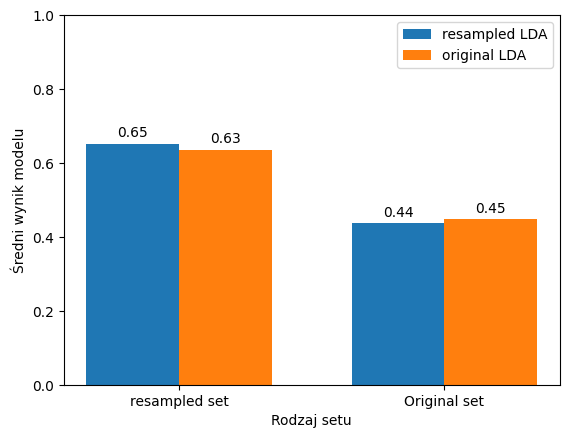

In [ ]:
draw_resampled_to_original_set_score_comparison("LDA",lda, resampled_lda,X_resampled_test, Y_resampled_test, X_test, Y_test)

<h7>Widać, że w przypadku LDA różnice pomiędzy wyborem setu uczącego model nie mają tak dużego znaczenia w porównaniu do setów które są wykorzystane do testowania modelu</h7>

<h3>Badanie jakości modeli na podstawie metryki "k top accuracy" dla różnej liczby akceptowanych klas</h3>

<h7>Metryka k_top_accuracy uznaje obiekt za poprawnie sklasyfikowany jeżeli prawdziwa klasa obieku znajduje się wśród k - najbardziej prawdopodobnych klas obiektu według testowanego modelu</h7>

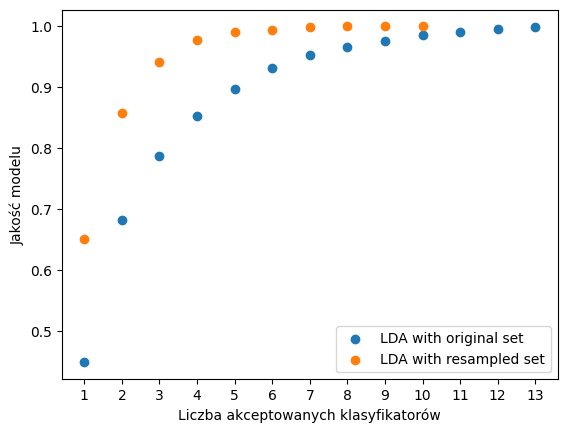

In [ ]:
lda_k_accuracy_scores = draw_chart_of_k_accuracy_score_of_models(
    [lda, resampled_lda], [X_test, X_resampled_test], [Y_test, Y_resampled_test],
    ["LDA with original set", "LDA with resampled set"])


<h5>Tabela ze skutecznością modeli LDA według metryki top_k_accuracy</h5>

In [171]:
get_k_accuracy_results_table(lda_k_accuracy_scores)

,Akceptowane klasy,LDA with original set score,LDA with resampled set score
0,1.0,0.447846,0.650884
1,2.0,0.681328,0.857415
2,3.0,0.786282,0.941769
3,4.0,0.852871,0.977959
4,5.0,0.897178,0.990204
5,6.0,0.932248,0.994558
6,7.0,0.952852,0.998912
7,8.0,0.966415,1.000000
8,9.0,0.976813,1.000000
9,10.0,0.985145,1.000000


<h1>Macierze pomyłek (Confusion matrix) dla modelu LDA</h1>

<h5>Macierze pomyłek pomagają w sprawdzaniu czy jakość predykcji zależy od klasy, która jest predykowana. Innymi słowami Confusion Matrix pomaga do sprawdzania czy są klasy, które są lepiej predykowane niż inne, a jeżeli są błednie predykowane to z czym były pomylone.</h5>

<h3>Macierz pomyłek LDA dla setu oryginalnego</h3>

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


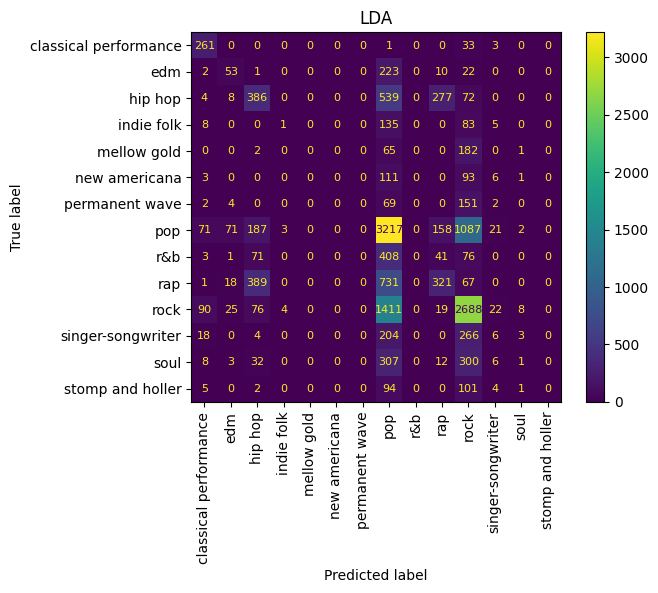

In [170]:
show_confusion_matrix(lda, X_test, Y_test)

<h7>Ze względu na naturę naszego zbioru danych widzimy, że większość pomyłek polegała na klasyfikacji wielu utworów jako pop lub rock. Powodów może być wiele. Jednym z nich na pewno jest niezbalansowanie setu i ogromna przewaga utworów popowych i rockowych ponad wszystkie inne. Innym powodem może być częste występowanie pop'u lub rocka w połączeniu z innymim gatunkami utworów , co w połączeniu z użytą strategią oceniania powoduje, że zostanie wzięty tylko bardziej prawdopodobny gatunek jakim będzie w wiekszości pop lub rock</h7>

<h7>Dodatkowo widzimy, że niesamowitą skutecznością predykcji cieszy się gatunek classical performance. Może być to związne z wcześniej wspomnianym rozkładem cechy instrumentallnes, która może służyć do bardzo precyzyjnej predykcji utorów klasycznych, które są z ich natury instrumentalne</h7>

<h3>Macierz pomyłek LDA dla setu ponownie próbkowanego</h3>

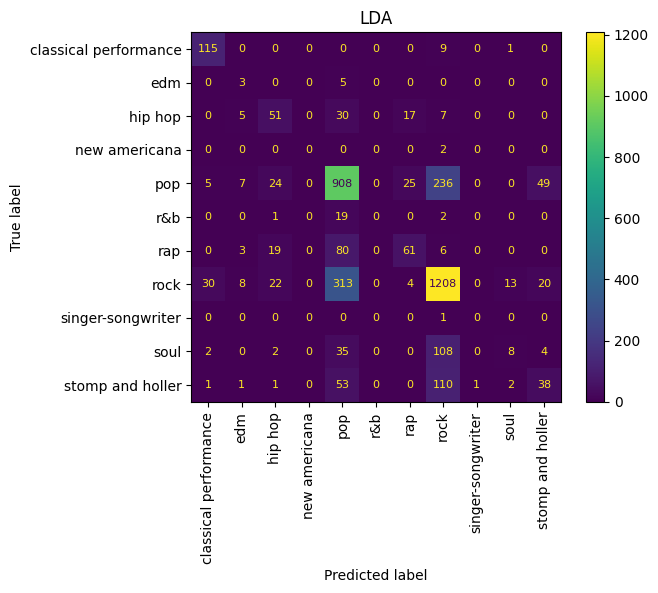

In [ ]:
show_confusion_matrix(resampled_lda, X_resampled_test, Y_resampled_test)

<h5>Na zresamplowanym secie własności wspomniane przy oryginalnym secie są nieco czytelniejsze</h5>

<h1>Cross validacja modelu z użyciem metryki top k accuracy</h1>

<h5>Wcześniejszy podzial na zbiór uczący i ćwiczący jest pomocny do analizy, lecz aby otrzymać bardziej równomiernie wyniki testów stosuje się cross validacje. Cross validacja dzieli zbiór na tzw. "foldy", na podstawie których set jest uczony i testowany. Liczba wyników jest równa liczbie foldów. Aby zdobyć prosty wyznacznik jakości modelu możemy obliczyć śrenią z tych wyników.</h5>

<h5>Cross validacja wymaga aby predykowane klasy obiektów były wartościami liczbowymi. W związku z tym wszystkie gatunki zostały zmapowane na odpowiadające im indeksy</h5>

In [ ]:
lda_with_genres_indexes = LinearDiscriminantAnalysis().fit(df[column_names], simplified_genres_as_indexes)

lda_cross_val_scores = cross_val_score(lda_with_genres_indexes,
                                       df[column_names],
                                       simplified_genres_as_indexes,
                                       cv=3,
                                       scoring=make_scorer(top_k_accuracy_score, k=3, needs_proba=True)).mean()
lda_cross_val_scores

0.776633784957081

In [271]:
resampled_lda_with_genres_indexes = LinearDiscriminantAnalysis().fit(nearest_neighbours_df[column_names], resampled_simplified_genres_as_indexes)

resampled_lda_cross_val_scores = cross_val_score(resampled_lda_with_genres_indexes,
                                       nearest_neighbours_df[column_names],
                                       resampled_simplified_genres_as_indexes,
                                       cv=3,
                                       scoring=make_scorer(top_k_accuracy_score, k=3, needs_proba=True)).mean()
resampled_lda_cross_val_scores

0.9344684057816464

<h1>SVC</h1>


<h3>Uczenie modelu SVC na podstawie zbioru uczącego</h3>

<h5>Aby utworzyć estymator wykorzystujemy make_pipeline oraz StandardScaler aby standaryzować zbiory, na których operuje ten model</h5>

In [294]:
svc = make_pipeline(StandardScaler(),SVC(gamma='auto', probability=True))

resampled_svc = make_pipeline(StandardScaler(),SVC(gamma='auto', probability=True))


In [295]:
svc.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', probability=True))])

<h5>Analogiczną procedurę wykonujemy dla modelu ćwiczonego na zbiorze ponownie próbkowanym</h5>

In [296]:
resampled_svc.fit(X_resampled_train, Y_resampled_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', probability=True))])

<h5>Sprawdzamy efektywność modeli za pomocą metryki średniej dokładności</h5>

In [297]:
svc.score(X_test, Y_test)

0.48323968223212554

In [298]:
resampled_svc.score(X_resampled_test, Y_resampled_test)

0.7235374149659864

<h5>Porównanie skuteczności modeli uczonych na zbiorach ponownie próbkowanych i oryginalnych na różnych zbiorach danych na podstawie średniej dokładności (mean accuracy)</h5>

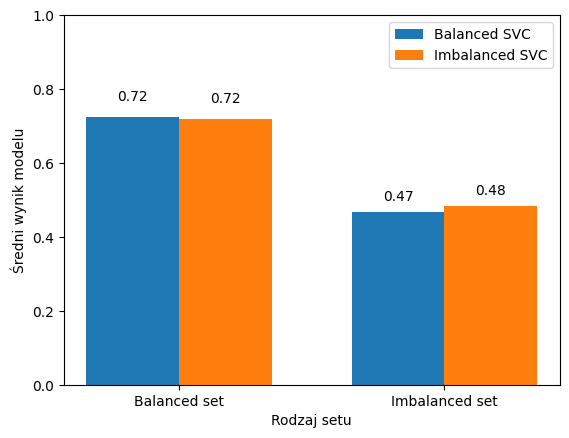

In [299]:
draw_resampled_to_original_set_score_comparison("SVC",
                                                 svc,
                                                 resampled_svc,
                                                 X_resampled_test, 
                                                 Y_resampled_test, 
                                                 X_test, 
                                                 Y_test)

<h5>Badanie jakości modeli na podstawie metryki k_top_accuracy dla różnej liczby akceptowanych klas</h5>

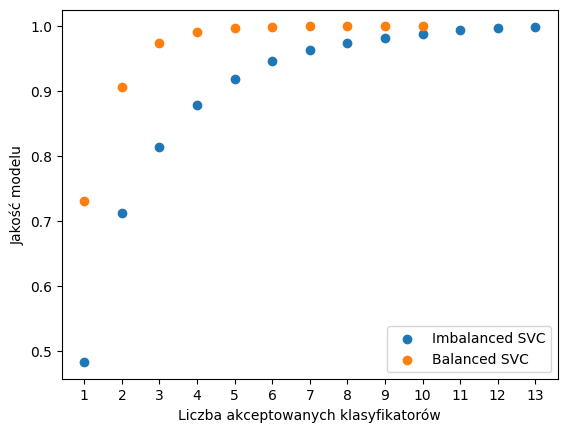

In [300]:
svc_k_accuracy_scores = draw_chart_of_k_accuracy_score_of_models(
    [svc, resampled_svc], [X_test, X_resampled_test], [Y_test, Y_resampled_test],
    ["original SVC", "resampled SVC"])

<h5>Tabela ze skutecznością modeli SVC według metryki top_k_accuracy</h5>

In [301]:
get_k_accuracy_results_table(svc_k_accuracy_scores)

,Akceptowane klasy,Imbalanced SVC score,Balanced SVC score
0,1.0,0.482917,0.731973
1,2.0,0.712523,0.906395
2,3.0,0.815023,0.974422
3,4.0,0.878383,0.992109
4,5.0,0.919395,0.997823
5,6.0,0.946974,0.998912
6,7.0,0.963960,1.000000
7,8.0,0.974682,1.000000
8,9.0,0.982497,1.000000
9,10.0,0.989020,1.000000


<h1>Macierze pomyłek (Confusion matrix) dla modeli SVC</h1>


<h3>Macierz pomyłek SVC dla setu niezbalansowanego</h3>

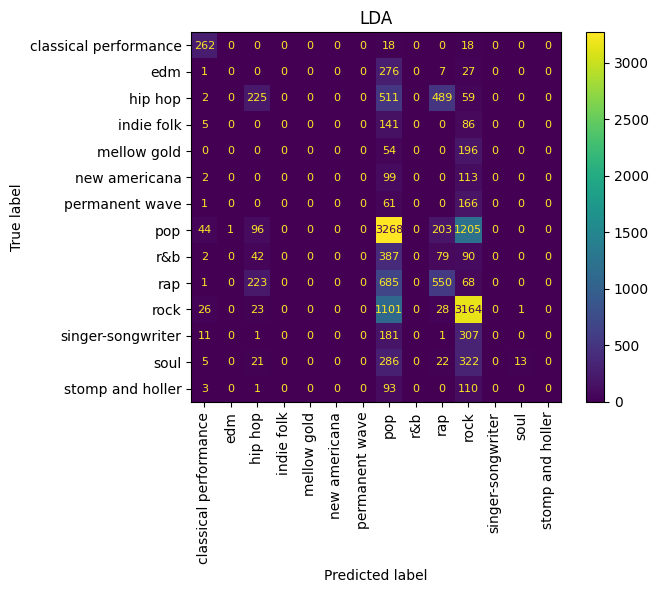

In [302]:
show_confusion_matrix(svc, X_test, Y_test)

<h3>Macierz pomyłek SVC dla setu zbalansowanego</h3>

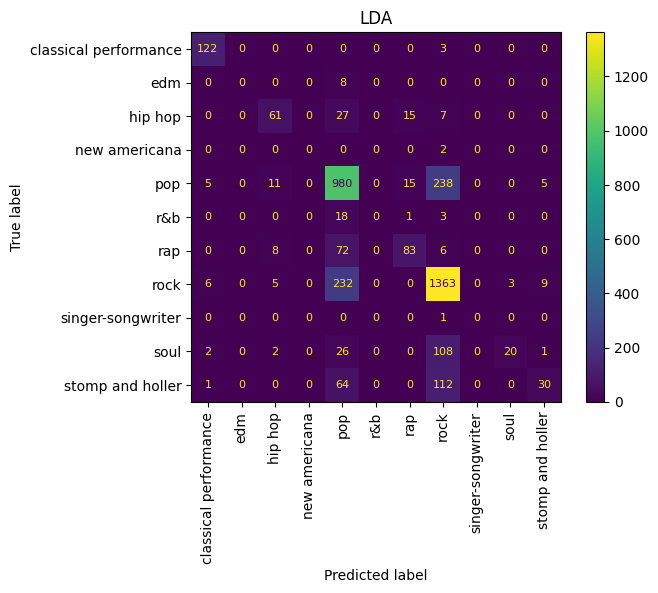

In [303]:
show_confusion_matrix(resampled_svc, X_resampled_test, Y_resampled_test)

<h1>Cross validacja SVC z użyciem metryki top_k_accuracy</h1>

In [304]:
svc_with_genres_indexes = make_pipeline(StandardScaler(),
                                        SVC(gamma="auto", probability=True))\
                                        .fit(df[column_names], simplified_genres_as_indexes)

svc_cross_val_scores = cross_val_score(lda_with_genres_indexes,
                                       df[column_names],
                                       simplified_genres_as_indexes,
                                       cv=3,
                                       scoring=make_scorer(top_k_accuracy_score, k=3, needs_proba=True)).mean()
svc_cross_val_scores

0.776633784957081

In [305]:
resampled_svc_with_genres_indexes = make_pipeline(StandardScaler(),
                                                 SVC(gamma="auto", probability=True))\
                                                    .fit(nearest_neighbours_df[column_names], resampled_simplified_genres_as_indexes)

resampled_svc_cross_val_scores = cross_val_score(resampled_svc_with_genres_indexes,
                                       nearest_neighbours_df[column_names],
                                       resampled_simplified_genres_as_indexes,
                                       cv=3,
                                       scoring=make_scorer(top_k_accuracy_score, k=3, needs_proba=True)).mean()
resampled_svc_cross_val_scores

0.9423062335319496

<h1>Random Forest Classifier</h1>

<h3>Uczenie modelu Random Forest Classifier na podstawie zbioru uczącego</h3>

In [241]:

rfc = RandomForestClassifier()

resampled_rfc = RandomForestClassifier()

In [242]:
rfc.fit(X_train,Y_train)
resampled_rfc.fit(X_resampled_train, Y_resampled_train)


RandomForestClassifier()

<h5>Sprawdzenie jakości modeli na podstawie metryki średniej dokładności</h5>

In [243]:
rfc.score(X_test, Y_test)

0.5426596912743008

In [244]:
resampled_rfc.score(X_resampled_test, Y_resampled_test)

0.939047619047619

<h3>Badanie wpływu zbalansowania setu na ćwiczenie i testowanie modelu</h3>

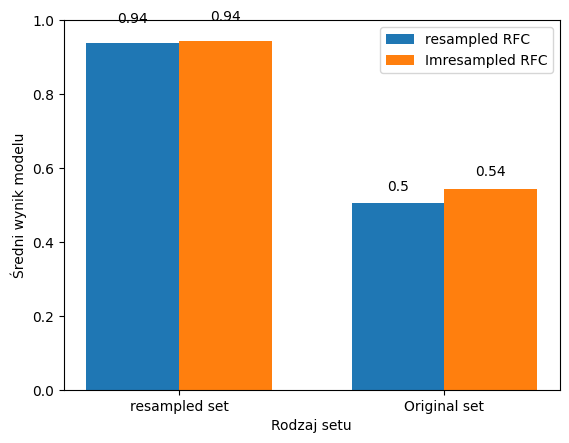

In [245]:

draw_resampled_to_original_set_score_comparison("RFC",
                                                 rfc,
                                                 resampled_rfc,
                                                 X_resampled_test, 
                                                 Y_resampled_test, 
                                                 X_test, 
                                                 Y_test)

<h3>Badanie efektywności modelu na podstawie metryki top_k_accuracy</h3>

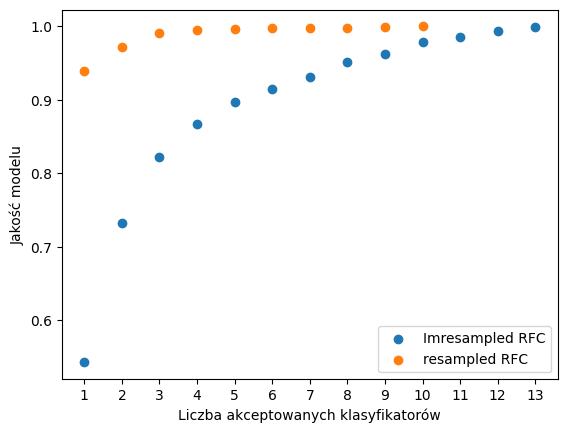

In [246]:
rfc_k_accuracy_scores = draw_chart_of_k_accuracy_score_of_models(
    [rfc, resampled_rfc], [X_test, X_resampled_test], [Y_test, Y_resampled_test],
    ["Imresampled RFC", "resampled RFC"])

<h5>Tabela ze skutecznością modeli RFC według metryki top_k_accuracy</h5>

In [253]:
get_k_accuracy_results_table(rfc_k_accuracy_scores)

,Akceptowane klasy,Imresampled RFC score,resampled RFC score
0,1.0,0.542660,0.939592
1,2.0,0.732158,0.971973
2,3.0,0.822773,0.991020
3,4.0,0.866693,0.995102
4,5.0,0.896790,0.996735
5,6.0,0.915326,0.998367
6,7.0,0.930957,0.998367
7,8.0,0.952012,0.998367
8,9.0,0.961829,0.998639
9,10.0,0.978686,1.000000


<h1>Macierze pomyłek</h1>

<h3>Macierz pomyłek RFC dla setu niezbalansowanego</h3>

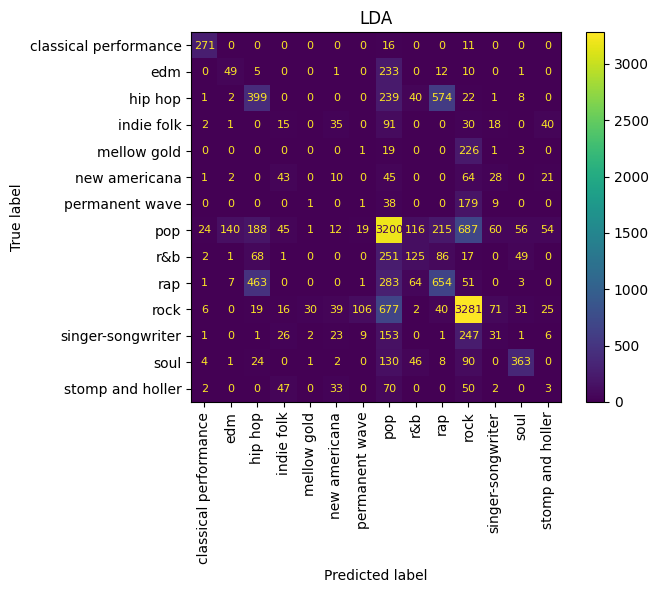

In [248]:
show_confusion_matrix(rfc, X_test, Y_test)

<h3>Macierz pomyłek RFC dla setu zbalansowanego</h3>

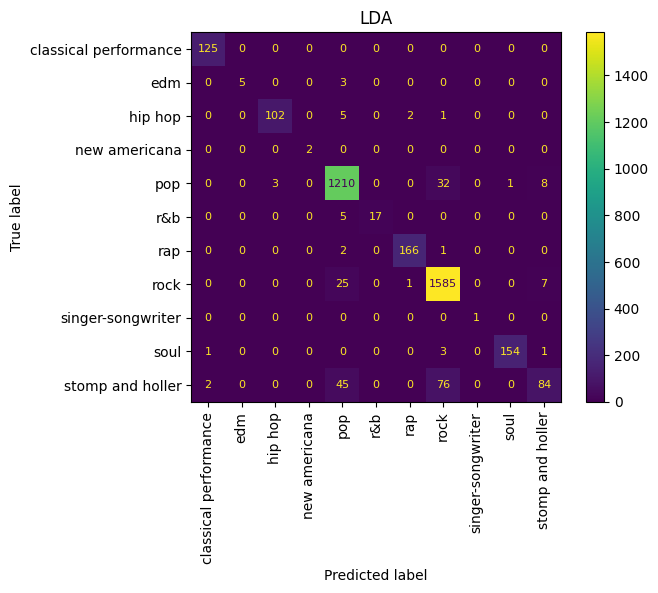

In [249]:
show_confusion_matrix(resampled_rfc, X_resampled_test, Y_resampled_test)

<h1>Cross validacja modelu RFC z użyciem metryki top_k_accuracy</h1>

In [250]:
rfc_with_genres_indexes = RandomForestClassifier().fit(df[column_names], simplified_genres_as_indexes)

rfc_cross_val_scores = cross_val_score(rfc_with_genres_indexes,
                                       df[column_names],
                                       simplified_genres_as_indexes,
                                       cv=3,
                                       scoring=make_scorer(top_k_accuracy_score, k=3, needs_proba=True)).mean()
rfc_cross_val_scores

0.7834160036487425

In [251]:
resampled_rfc_with_genres_indexes = RandomForestClassifier().fit(nearest_neighbours_df[column_names], resampled_simplified_genres_as_indexes)

resampled_rfc_cross_val_scores = cross_val_score(resampled_rfc_with_genres_indexes,
                                       nearest_neighbours_df[column_names],
                                       resampled_simplified_genres_as_indexes,
                                       cv=3,
                                       scoring=make_scorer(top_k_accuracy_score, k=3, needs_proba=True)).mean()
resampled_rfc_cross_val_scores

0.9475314342588766

<h1>Porównanie modeli LDA, RFC i SVC</h1>

<h3>Porównanie modeli na podstawie metryki k top accuracy dla każdego k</h3>

In [293]:
def combine_top_k_accuracy_scores_of_models(accuracy_score_dicts:list):
    """
    Return dictionary with combined scores for each accuracy_score_dict provided in accuracy_score_dicts
    accuracy_score_dict: contains key and list of values representing number of accepted classes for each row. 
    Dictionary also should contain key and list of values for each model variation we want to compare against
    """
    combined_scores ={}
    for accuracy_score_dict in accuracy_score_dicts:
        for accuracy_score_dict_key,accuracy_score_dict_value  in accuracy_score_dict.items():
            combined_scores[accuracy_score_dict_key] = accuracy_score_dict_value 

    return combined_scores

def pad_list_with_values(original_list, pad_value, max_size):
    """
    Padd original_list with value from pad_value, so that lists size is max_size
    """
    for i in range(max_size-len(original_list)):
        original_list.append(pad_value)
    return original_list

def draw_combined_k_accuracy_scores(combined_accuracy_scores):
    _,ax = plt.subplots()
    number_of_classes_key = "Akceptowane klasy"
    for combined_accracy_score_key, combined_accracy_score_values in combined_accuracy_scores.items():
        if combined_accracy_score_key!=number_of_classes_key:
            padded_values = pad_list_with_values(combined_accracy_score_values, 1, len(combined_accuracy_scores[number_of_classes_key]))

            ax.scatter(x=combined_accuracy_scores[number_of_classes_key],
                       y=combined_accracy_score_values,
                       label=combined_accracy_score_key)
    
    ax.set_xlabel("Liczba akceptowanych klasyfikatorów")
    ax.set_ylabel("Jakość modelu")
    loc = plticker.MultipleLocator(base=1.0)
    ax.xaxis.set_major_locator(loc) 
    plt.legend(loc='lower right')
    plt.title("Porównanie jakości modeli według metryki k top accuracy")
    plt.show()

models_combained_top_k_accuracy_scores = combine_top_k_accuracy_scores_of_models([rfc_k_accuracy_scores,lda_k_accuracy_scores])
get_k_accuracy_results_table(models_combained_top_k_accuracy_scores)

,Akceptowane klasy,Imresampled RFC score,resampled RFC score,LDA with original set score,LDA with resampled set score
0,1.0,0.542660,0.939592,0.447846,0.650884
1,2.0,0.732158,0.971973,0.681328,0.857415
2,3.0,0.822773,0.991020,0.786282,0.941769
3,4.0,0.866693,0.995102,0.852871,0.977959
4,5.0,0.896790,0.996735,0.897178,0.990204
5,6.0,0.915326,0.998367,0.932248,0.994558
6,7.0,0.930957,0.998367,0.952852,0.998912
7,8.0,0.952012,0.998367,0.966415,1.000000
8,9.0,0.961829,0.998639,0.976813,1.000000
9,10.0,0.978686,1.000000,0.985145,1.000000


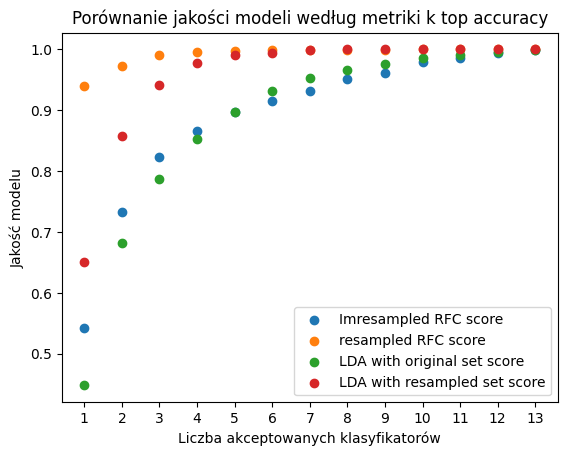

In [294]:
draw_combined_k_accuracy_scores(models_combained_top_k_accuracy_scores)

<h1>Porównanie jakości modeli na podstawie metryki top k accuracy w ramach cross validacji</h1>

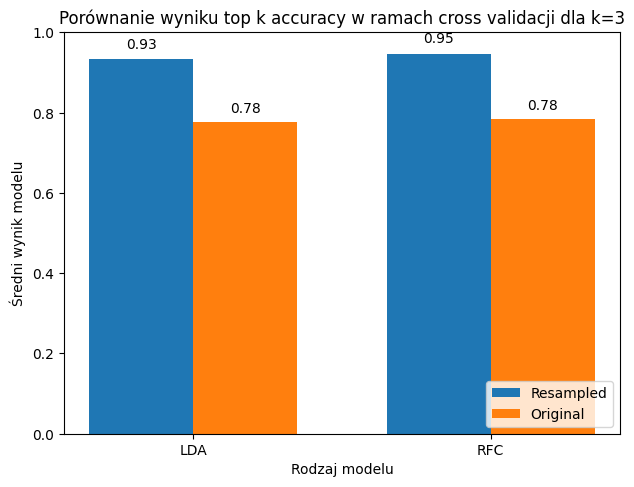

In [300]:
fix, ax = plt.subplots()
width=0.35
resampled_bars = ax.bar(height=[resampled_lda_cross_val_scores,
                      resampled_rfc_cross_val_scores
                      ],
              x=["LDA","RFC"],
              width=-width,
              label="Resampled",
              align="edge")
original_bars = ax.bar(height=[lda_cross_val_scores, rfc_cross_val_scores], 
        x=["LDA",  
                "RFC"],
        width=width,
        label="Original",
        align="edge")

plt.legend(loc='lower right')
put_label_on_a_bar(resampled_bars)
put_label_on_a_bar(original_bars)
ax.set_ylabel("Średni wynik modelu")
ax.set_xlabel("Rodzaj modelu")
ax.set_ylim(bottom=0,top=1)
plt.tight_layout()
plt.title("Porównanie wyniku top k accuracy w ramach cross validacji dla k=3")
plt.show()


In [285]:

def better_printing_decorator(message,func):

    def inner_better_printing_decrator(a,b):
         func_result = func(a,b)
         print(str(func_result), message)
         return func_result
    

    return inner_better_printing_decrator



decorator_function = better_printing_decorator("gort", lambda a,b: a+b)

decorator_function(5,7)
decorator_function(10,20)




12 gort
30 gort


30